In [1]:
! pip install kaggle


In [2]:
! mkdir ~/.kaggle



mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d nikitarom/planets-dataset

 99% 1.48G/1.50G [00:09<00:00, 186MB/s]
100% 1.50G/1.50G [00:09<00:00, 171MB/s]


In [5]:
! unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import numpy as np
import pandas as pd
from fastai.vision import *

In [23]:
path = Path("../content/planet/planet/")
path.ls()

[PosixPath('../content/planet/planet/train_classes.csv'),
 PosixPath('../content/planet/planet/sample_submission.csv'),
 PosixPath('../content/planet/planet/train-jpg'),
 PosixPath('../content/planet/planet/test-jpg')]

In [24]:
df = pd.read_csv(path/"train_classes.csv")
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [16]:
tfms = get_transforms(flip_vert = True, max_lighting = 0.1, max_zoom = 1.05, max_warp = 0.)

In [25]:
np.random.seed(7)
source = (ImageList.from_csv(path, "train_classes.csv", folder = "train-jpg", suffix = ".jpg").split_by_rand_pct(0.2).label_from_df(cols = "tags", label_delim = " "))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [26]:
data = (source.transform(tfms, size = 128)
       .databunch()
       .normalize(imagenet_stats))

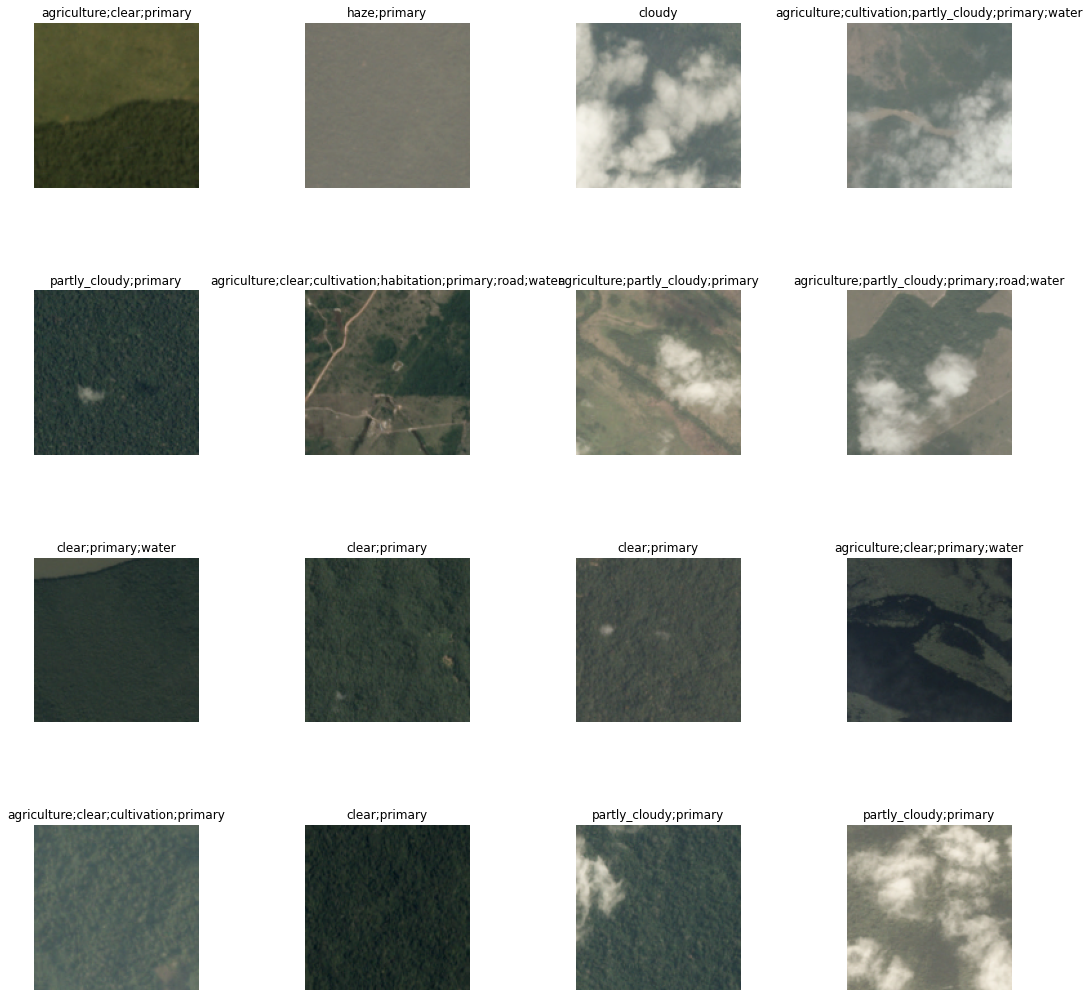

In [27]:
data.show_batch(rows = 4, figsize = (15,15))

In [28]:
acc_thresh = partial(accuracy_thresh, thresh = 0.2)
f2_score = partial(fbeta, beta = 2, thresh = 0.2)

In [29]:
learn = cnn_learner(data, models.resnet50, metrics = [acc_thresh, f2_score], model_dir = "/tmp/models")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


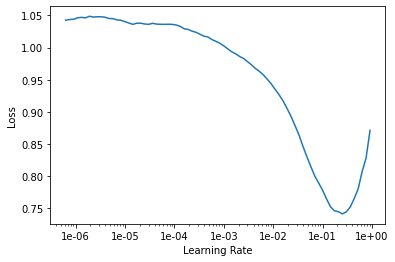

In [30]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len = 5, max_lr = slice(1e-2))

In [32]:
learn.save("baseline-rn50-128")

In [33]:
np.random.seed(7)
data2 = (source.transform(tfms, size = 256)
        .databunch()
        .normalize(imagenet_stats))

In [34]:
learn2 = cnn_learner(data2, models.resnet50, metrics = [acc_thresh, f2_score], model_dir = "/tmp/models")

In [ ]:
learn2.lr_find()
learn2.recorder.plot()

In [ ]:
lr = 3e-2
learn2.fit_one_cycle(cyc_len = 5, max_lr = slice(lr))

In [37]:
learn2.save("baseline-rn50-256")

In [ ]:
learn2.unfreeze()
learn2.lr_find()
learn2.recorder.plot()

In [ ]:
learn2.fit_one_cycle(cyc_len = 10, max_lr = slice(1e-5, lr/10))

In [ ]:
learn2.recorder.plot_losses()

In [41]:
learn2.save("stage-2-rn50-256")

In [ ]:
learn2.export(file = "../working/export.pkl")

In [ ]:
test = ImageList.from_folder(path/"test-jpg-v2")
len(test)

In [ ]:
load_path = Path("../working/")

learn = load_learner(load_path, test=test)
predicts, _ = learn.get_preds(ds_type = DatasetType.Test)

In [ ]:
labels_pred = [" ".join([learn.data.classes[i] for i,p in enumerate(pred) if p > 0.2]) for pred in predicts]

labels_pred[:5]

In [ ]:
for img in learn.data.test_ds.items[:10]:
    print(img.name)

In [ ]:
image_names = [img.name[:-4] for img in learn.data.test_ds.items]

In [ ]:
df2 = pd.DataFrame({"image_name":image_names, "tags":labels_pred})
df2.head()

In [ ]:
df2.to_csv("submission.csv", index = False)